# Environmental setting

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/263-NLP/Final_Project

/content/drive/MyDrive/263-NLP/Final_Project


# Change the kernel into Gpu

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')

# Data preprocess

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
data_path = 'data/holy_data/clean_af_data.csv'
data = pd.read_csv(data_path)

In [ ]:
# this step is to delete the empty string
drop_empty1 = data.dropna(subset=["text1"])
drop_empty2 = drop_empty1.dropna(subset=["text2"])
final_data = drop_empty2

In [ ]:
# split the data into train and test
from sklearn.model_selection import train_test_split
train, test = train_test_split(final_data, test_size=0.2)

In [ ]:
# convert the label into 4 classes
def convertLabel(label):
    if label - 1 > 0 and label - 1 < 0.5:
        label = 1
    elif label - 2 >= -0.5 and label - 2 < 0.5:
        label = 2
    elif label - 3 >= -0.5 and label - 3 < 0.5:
        label = 3
    elif label - 4 >= -0.5:
        label = 4
    return label
    
train_labels = train["Overall"]
train_labels  = train_labels .apply(convertLabel)
train_labels  = pd.Series.tolist(train_labels )
train_labels  = np.array(train_labels )

test_labels = test["Overall"]
test_labels  = test_labels .apply(convertLabel)
test_labels  = pd.Series.tolist(test_labels )
test_labels  = np.array(test_labels )

In [ ]:
# change 10 classes into 4 labels
def change_to_4classes(data):
  temp = []
  for i in data:
    if i == 1:
      temp.append([1,0,0,0])
    elif i == 2:
      temp.append([0,1,0,0])
    elif i == 3:
      temp.append([0,0,1,0])
    else:
      temp.append([0,0,0,1])
  temp = np.array(temp)
  return temp

train_label = change_to_4classes(train_labels)
test_label = change_to_4classes(test_labels)


# Doc embedding


In [ ]:
! pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

sentences_1 = pd.Series.tolist(train["text1"])
sentences_2 = pd.Series.tolist(train["text2"])

# embedding of every doc
train1 = encoder.encode(sentences_1)
train2 = encoder.encode(sentences_2)

print(train1.shape)
print(train2.shape)

(3213, 384)
(3213, 384)


In [ ]:
from sentence_transformers import SentenceTransformer
encoder = SentenceTransformer('paraphrase-MiniLM-L6-v2')

test_1 = pd.Series.tolist(test["text1"])
test_2 = pd.Series.tolist(test["text2"])

# embedding of every doc
test1 = encoder.encode(test_1)
test2 = encoder.encode(test_2)

print(test1.shape)
print(test2.shape)

(804, 384)
(804, 384)


# Reshape input data for CNN

In [ ]:
train_input =  np.concatenate((train1, train2, train1-train2),axis = 1)
test_input =  np.concatenate((test1, test2, test1-test2),axis = 1)
# reshape to fit dimensional of the CNN model, the desire shape should be (3213, 1, 1152) and (804, 1, 1152)
train_input_cnn = train_input.reshape((train_input.shape[0], 1 , train_input.shape[1]))
test_input_cnn = test_input.reshape((test_input.shape[0], 1 , test_input.shape[1]))

In [ ]:
print(train_input_cnn.shape, test_input_cnn.shape)

(3213, 1, 1152) (804, 1, 1152)


# CNN Model set up

In [ ]:
!pip install tensorflow

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, LSTM, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
## Hyper Parameters
learning_rate = 0.003
lr_decay = 0.01
eps = 1e-8
epoch_num = 20
batch_size = 20

In [ ]:
## Variables
# channels_in_1, channels_out_1, kernel_size_1, stride_1 = 1, 16, (1, 6), 1
# pool_size_1, pool_stride_1 = (1, 3), 1
# channels_out_2, kernel_size_2, stride_2 = 32, (1, 3), 1
# pool_size_2, pool_stride_2 = (1, 3), 1
# channels_out_3, kernel_size_3, stride_3 = 64, (1, 5), 1
# hiddendim_1, hiddendim_2, hiddendim_3 = 128, 64, 32
# num_classes = 4

In [ ]:
def CNN_model(kernel_initializer, params, time=1152):

    lr, dropout_rate = params

    channels_in_1, channels_out_1, kernel_size_1, stride_1 = 1, 16, (1, 6), 1
    pool_size_1, pool_stride_1 = (1, 3), 1
    channels_out_2, kernel_size_2, stride_2 = 32, (1, 3), 1
    pool_size_2, pool_stride_2 = (1, 3), 1
    channels_out_3, kernel_size_3, stride_3 = 64, (1, 5), 1
    hiddendim_1, hiddendim_2, hiddendim_3 = 128, 64, 32
    num_classes = 4
    
    model = Sequential(
        [
         Conv2D(channels_out_1, kernel_size=kernel_size_1, strides=stride_1, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), 
                     input_shape=(channels_in_1, time, 1), data_format='channels_last', activation='elu'),
         BatchNormalization(axis=1),
         Dropout(dropout_rate),
         Conv2D(channels_out_2, kernel_size=kernel_size_2, strides=stride_2, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), activation='elu'),
         BatchNormalization(axis=1),
         Dropout(dropout_rate),
         MaxPool2D(pool_size_1),
         Conv2D(channels_out_3, kernel_size=kernel_size_3, strides=stride_3, padding='valid', kernel_regularizer=L1L2(l1=0, l2=0.01), activation='elu'),
         BatchNormalization(axis=1),
         Dropout(dropout_rate),
         MaxPool2D(pool_size_2),

        #  Permute((2, 3, 1)),
         Flatten(),

         Dense(128, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='elu'),
         Dense(64, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='elu'),
         Dense(32, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='elu'),
         Dense(num_classes, kernel_regularizer=L1L2(l1=0, l2=0.01), activation='softmax'),
        ]
    )
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr, epsilon=eps, decay=lr_decay), metrics=[categorical_accuracy])
    return model

# Train CNN model

In [ ]:
def train(X_train, y_train, X_test, y_test, params):
    # model setup
    model = CNN_model(lecun_uniform(seed=42), params)

    X_train = np.expand_dims(X_train, axis=3)
    X_test = np.expand_dims(X_test, axis=3)

    model.fit(X_train, y_train, epochs=epoch_num, batch_size=batch_size, validation_data=(X_test, y_test), shuffle=True, verbose=1)
    train_score = model.evaluate(X_train, y_train)
    test_score = model.evaluate(X_test, y_test)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    print(model.summary())
    
    return train_score, test_score

In [ ]:
train_score, test_score = train(train_input_cnn, train_label, test_input_cnn, test_label, [0.003, 0.2])

# Reshape data for RNN model


In [ ]:
# reshape to fit dimensional of the RNN model, the desire shape should be (3213, 1152, 1,1) and (804, 1152, 1, 1)
train_input_rnn = train_input_cnn.reshape((train_input_cnn.shape[0],  train_input_cnn.shape[2], train_input_cnn.shape[1],  1))
test_input_rnn = test_input_cnn.reshape((test_input_cnn.shape[0], test_input_cnn.shape[2],test_input_cnn.shape[1],  1))
# train_input_rnn = train_input
# test_input_rnn = test_input
print(train_input_rnn.shape)


(3213, 1152, 1, 1)


# RNN Model set up

In [ ]:
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Permute, Bidirectional, BatchNormalization, Conv2D, LSTM, Dense, Dropout, ELU, Flatten, MaxPool2D, TimeDistributed, Dense
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.initializers import lecun_uniform
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# if the kernel size is 10, the training acc can go up til 80 sth, but the test acc is only 40
# if the kernel size is less than 10, the traning acc is 60 sth, but the test acc is around 50
# in some cases of the parameters in NN Final project, some will
def RNN_model(kernel_initializer, params):

    lr, dropout_rate = params

    channels_in_1, channels_out_1, kernel_size_1, stride_1 = (1152,1,1), 32, (6, 1), 1
    pool_size_1, pool_stride_1 = (4, 1), 1
    channels_out_2, kernel_size_2, stride_2 = 64, (6, 1), 1
    pool_size_2, pool_stride_2 = (4, 1), 1
    channels_out_3, kernel_size_3, stride_3 = 128, (5, 1), 1
    pool_size_3, pool_stride_3 = (4, 1), 1
    channels_out_4, kernel_size_4, stride_4 = 256, (4, 1), 1
    pool_size_4, pool_stride_4 = (4, 1), 1
    hiddendim_1, hiddendim_2, hiddendim_3 = 128, 64, 32

    model = Sequential(
        [
        Conv2D(filters=channels_out_1, kernel_size=kernel_size_1, padding='same', activation='elu', input_shape=channels_in_1),
        MaxPool2D(pool_size=pool_size_1, padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Conv2D(filters=channels_out_2, kernel_size=kernel_size_2, padding='same', activation='elu'),
        MaxPool2D(pool_size=pool_size_2, padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Conv2D(filters=channels_out_3, kernel_size=kernel_size_3, padding='same', activation='elu'),
        MaxPool2D(pool_size=pool_size_3, padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),

        Conv2D(filters=channels_out_4, kernel_size=kernel_size_4, padding='same', activation='elu'),
        MaxPool2D(pool_size=pool_size_4, padding='same'),
        BatchNormalization(),
        Dropout(dropout_rate),
         
        Permute((2, 3, 1)),
        TimeDistributed(Flatten()),
        Bidirectional(LSTM(hiddendim_1, kernel_initializer=kernel_initializer, return_sequences=True)),
        Bidirectional(LSTM(hiddendim_2, kernel_initializer=kernel_initializer, return_sequences=True)),
        Bidirectional(LSTM(hiddendim_3, kernel_initializer=kernel_initializer)),
        Dropout(dropout_rate),

        Dense(num_classes, activation='softmax'),
        ]
    )
    model.compile(loss='categorical_crossentropy', 
                  optimizer=Adam(learning_rate=lr),
                  metrics=[categorical_accuracy])
    return model



# Train RNN model

In [ ]:
def train(model, params, data):
    epoch_num, batch_size = params
    x_train, y_train, x_test, y_test= data

    model.fit(x_train, y_train, epochs=epoch_num, batch_size=batch_size, 
              validation_data=(x_test, y_test), shuffle=True, verbose=1)
    train_score = model.evaluate(x_train, y_train)
    test_score = model.evaluate(x_test, y_test)

    print('train {:s}: {:.3f}%'.format(model.metrics_names[1], train_score[1]*100))
    print('test {:s}: {:.3f}%'.format(model.metrics_names[1], test_score[1]*100))
    
    return train_score, test_score

# Dont need to run when fine tuning

In [ ]:
# This is an individual training process and DONT RUN IT FOR FINE TUNING PART
learning_rate = 0.001
epoch_num = 40
batch_size = 80
dropout_rate = 0.5
num_classes = 4
model1_RNN = RNN_model(lecun_uniform(seed=42), [learning_rate, dropout_rate])
train_score, test_score = train(model1_RNN,
                                [epoch_num, batch_size],
                                [train_input, train_label, test_input, test_label]
                                )

In [ ]:
# for some reasons it couldn't work, but it would help to build a better structure
plot_model(
    RNN_model,
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=True
)

# Grid search to fine tuning


In [ ]:
# u may try to tune the parameters seperately first, just like what we did last quarter, or u can just combine them together
num_classes = 4
lrs = [1e-3, 5e-4, 3e-4]
bzs = [20, 30, 50]
drops = [0.2, 0.25, 0.3]
rs_rnn = [ ]
for lr in lrs:
  for drop in drops:
    for bz in bzs:
      model1_RNN = RNN_model(lecun_uniform(seed=42), [lr, drop])
      train_acc, test_acc = train(model1_RNN,
                                  [epoch_num, bz],
                                  [train_input_rnn, train_label, test_input_rnn, test_label]
                                  )
      rs_rnn.append((lr, drop, bz, train_acc, test_acc))

Epoch 1/20
161/161 [==============================] - 25s 31ms/step - loss: 1.2151 - categorical_accuracy: 0.4522 - val_loss: 1.3374 - val_categorical_accuracy: 0.2749
Epoch 2/20
161/161 [==============================] - 2s 14ms/step - loss: 1.1488 - categorical_accuracy: 0.4911 - val_loss: 1.2906 - val_categorical_accuracy: 0.3644
Epoch 3/20
161/161 [==============================] - 2s 14ms/step - loss: 1.0984 - categorical_accuracy: 0.5114 - val_loss: 1.1723 - val_categorical_accuracy: 0.4478
Epoch 4/20
161/161 [==============================] - 2s 14ms/step - loss: 1.0653 - categorical_accuracy: 0.5363 - val_loss: 1.1301 - val_categorical_accuracy: 0.4751
Epoch 5/20
161/161 [==============================] - 2s 15ms/step - loss: 1.0179 - categorical_accuracy: 0.5537 - val_loss: 1.0995 - val_categorical_accuracy: 0.5137
Epoch 6/20
161/161 [==============================] - 2s 14ms/step - loss: 0.9572 - categorical_accuracy: 0.5780 - val_loss: 1.1633 - val_categorical_accuracy: 0.47

In [ ]:
print(rs_rnn)

[(0.001, 0.2, 20, [0.173028364777565, 0.9511359930038452], [1.6306384801864624, 0.45895522832870483]), (0.001, 0.2, 30, [0.1506350189447403, 0.9561157822608948], [1.70020592212677, 0.49378108978271484]), (0.001, 0.2, 50, [0.13473592698574066, 0.9554933309555054], [1.8748624324798584, 0.4614427983760834]), (0.001, 0.25, 20, [0.23289667069911957, 0.932150661945343], [1.5375261306762695, 0.4776119291782379]), (0.001, 0.25, 30, [0.3513495922088623, 0.8755057454109192], [1.5844725370407104, 0.45398008823394775]), (0.001, 0.25, 50, [0.22111180424690247, 0.9355742335319519], [1.5854079723358154, 0.4726368188858032]), (0.001, 0.3, 20, [0.4998883008956909, 0.8235294222831726], [1.3768993616104126, 0.45398008823394775]), (0.001, 0.3, 30, [0.4065498113632202, 0.860255241394043], [1.397220253944397, 0.46766167879104614]), (0.001, 0.3, 50, [0.5248938798904419, 0.7986305356025696], [1.3579938411712646, 0.4912935197353363]), (0.0005, 0.2, 20, [0.10128837078809738, 0.9688764214515686], [1.781397461891

In [ ]:
rnn_rs = [(0.001, 0.2, 20, [0.173028364777565, 0.9511359930038452], [1.6306384801864624, 0.45895522832870483]), (0.001, 0.2, 30, [0.1506350189447403, 0.9561157822608948], [1.70020592212677, 0.49378108978271484]), (0.001, 0.2, 50, [0.13473592698574066, 0.9554933309555054], [1.8748624324798584, 0.4614427983760834]), (0.001, 0.25, 20, [0.23289667069911957, 0.932150661945343], [1.5375261306762695, 0.4776119291782379]), (0.001, 0.25, 30, [0.3513495922088623, 0.8755057454109192], [1.5844725370407104, 0.45398008823394775]), (0.001, 0.25, 50, [0.22111180424690247, 0.9355742335319519], [1.5854079723358154, 0.4726368188858032]), (0.001, 0.3, 20, [0.4998883008956909, 0.8235294222831726], [1.3768993616104126, 0.45398008823394775]), (0.001, 0.3, 30, [0.4065498113632202, 0.860255241394043], [1.397220253944397, 0.46766167879104614]), (0.001, 0.3, 50, [0.5248938798904419, 0.7986305356025696], [1.3579938411712646, 0.4912935197353363]), (0.0005, 0.2, 20, [0.10128837078809738, 0.9688764214515686], [1.7813974618911743, 0.48009949922561646]), (0.0005, 0.2, 30, [0.14282329380512238, 0.9530034065246582], [1.8531888723373413, 0.4552238881587982]), (0.0005, 0.2, 50, [0.15231384336948395, 0.9617180228233337], [1.7244765758514404, 0.4614427983760834]), (0.0005, 0.25, 20, [0.2564335763454437, 0.924369752407074], [1.6295390129089355, 0.45895522832870483]), (0.0005, 0.25, 30, [0.28845319151878357, 0.9181450605392456], [1.4148411750793457, 0.45771142840385437]), (0.0005, 0.25, 50, [0.3554709851741791, 0.8667911887168884], [1.5094473361968994, 0.4203979969024658]), (0.0005, 0.3, 20, [0.4263973832130432, 0.8387799859046936], [1.379940152168274, 0.48383083939552307]), (0.0005, 0.3, 30, [0.4991934299468994, 0.8067227005958557], [1.3508663177490234, 0.4738805890083313]), (0.0005, 0.3, 50, [0.6415886282920837, 0.7587924003601074], [1.2791134119033813, 0.46641790866851807]), (0.0003, 0.2, 20, [0.1776534914970398, 0.9452225565910339], [1.5613510608673096, 0.4900497496128082]), (0.0003, 0.2, 30, [0.22818322479724884, 0.9411764740943909], [1.5403985977172852, 0.4639303386211395]), (0.0003, 0.2, 50, [0.33854737877845764, 0.8860877752304077], [1.4341903924942017, 0.46641790866851807]), (0.0003, 0.25, 20, [0.38628360629081726, 0.8786181211471558], [1.3620460033416748, 0.46268656849861145]), (0.0003, 0.25, 30, [0.47869688272476196, 0.839402437210083], [1.298897624015808, 0.46268656849861145]), (0.0003, 0.25, 50, [0.5588000416755676, 0.7849361896514893], [1.3630837202072144, 0.4689054787158966]), (0.0003, 0.3, 20, [0.6190566420555115, 0.7784002423286438], [1.2396619319915771, 0.4552238881587982]), (0.0003, 0.3, 30, [0.7053331136703491, 0.7233115434646606], [1.1358016729354858, 0.48507463932037354]), (0.0003, 0.3, 50, [0.7750189304351807, 0.6794273257255554], [1.1898480653762817, 0.4701492488384247])]

In [ ]:
for element in rnn_rs:
    print("lr: {}".format(element[0]), "dropout rate: {}".format(element[1]), "batch size: {}".format(element[2]), "accuracy: {}".format(element[4][1]))

lr: 0.001 dropout rate: 0.2 batch size: 20 accuracy: 0.45895522832870483
lr: 0.001 dropout rate: 0.2 batch size: 30 accuracy: 0.49378108978271484
lr: 0.001 dropout rate: 0.2 batch size: 50 accuracy: 0.4614427983760834
lr: 0.001 dropout rate: 0.25 batch size: 20 accuracy: 0.4776119291782379
lr: 0.001 dropout rate: 0.25 batch size: 30 accuracy: 0.45398008823394775
lr: 0.001 dropout rate: 0.25 batch size: 50 accuracy: 0.4726368188858032
lr: 0.001 dropout rate: 0.3 batch size: 20 accuracy: 0.45398008823394775
lr: 0.001 dropout rate: 0.3 batch size: 30 accuracy: 0.46766167879104614
lr: 0.001 dropout rate: 0.3 batch size: 50 accuracy: 0.4912935197353363
lr: 0.0005 dropout rate: 0.2 batch size: 20 accuracy: 0.48009949922561646
lr: 0.0005 dropout rate: 0.2 batch size: 30 accuracy: 0.4552238881587982
lr: 0.0005 dropout rate: 0.2 batch size: 50 accuracy: 0.4614427983760834
lr: 0.0005 dropout rate: 0.25 batch size: 20 accuracy: 0.45895522832870483
lr: 0.0005 dropout rate: 0.25 batch size: 30 accu

In [ ]:
lrs = [1e-3, 5e-4, 3e-4]
bzs = [20, 30, 50]
drops = [0.2, 0.25, 0.3]
rs_cnn = [ ]
for lr in lrs:
  for drop in drops:
    for bz in bzs:
      model2_CNN = CNN_model(lecun_uniform(seed=42), [lr, drop])
      train_acc, test_acc = train(model2_CNN,
                                  [epoch_num, bz],
                                  [train_input_cnn, train_label, test_input_cnn, test_label]
                                  )
      rs_cnn.append((lr, drop, bz, train_acc, test_acc))

Epoch 1/20
161/161 [==============================] - 8s 45ms/step - loss: 4.9540 - categorical_accuracy: 0.4217 - val_loss: 6.4897 - val_categorical_accuracy: 0.2301
Epoch 2/20
161/161 [==============================] - 1s 9ms/step - loss: 3.6363 - categorical_accuracy: 0.4784 - val_loss: 4.6818 - val_categorical_accuracy: 0.2388
Epoch 3/20
161/161 [==============================] - 1s 8ms/step - loss: 3.1999 - categorical_accuracy: 0.5173 - val_loss: 3.1940 - val_categorical_accuracy: 0.4515
Epoch 4/20
161/161 [==============================] - 1s 8ms/step - loss: 2.9350 - categorical_accuracy: 0.5335 - val_loss: 2.9287 - val_categorical_accuracy: 0.5075
Epoch 5/20
161/161 [==============================] - 1s 8ms/step - loss: 2.7589 - categorical_accuracy: 0.5524 - val_loss: 2.7841 - val_categorical_accuracy: 0.5025
Epoch 6/20
161/161 [==============================] - 1s 8ms/step - loss: 2.6299 - categorical_accuracy: 0.5612 - val_loss: 2.6761 - val_categorical_accuracy: 0.5100
Epo

In [ ]:
print(rs_cnn)

[(0.001, 0.2, 20, [1.7938928604125977, 0.7696856260299683], [2.3093245029449463, 0.5111940503120422]), (0.001, 0.2, 30, [1.6706624031066895, 0.7254902124404907], [2.0861454010009766, 0.5099502205848694]), (0.001, 0.2, 50, [1.8908683061599731, 0.684407114982605], [2.3126089572906494, 0.4863184094429016]), (0.001, 0.25, 20, [1.5644896030426025, 0.7189542651176453], [1.9030611515045166, 0.5099502205848694]), (0.001, 0.25, 30, [1.859054684638977, 0.653905987739563], [2.165555953979492, 0.5062189102172852]), (0.001, 0.25, 50, [1.9729182720184326, 0.6837846040725708], [2.2718069553375244, 0.4863184094429016]), (0.001, 0.3, 20, [1.9160834550857544, 0.6377217769622803], [2.2082619667053223, 0.4987562298774719]), (0.001, 0.3, 30, [1.9533114433288574, 0.6100217700004578], [2.193406343460083, 0.47512438893318176]), (0.001, 0.3, 50, [1.871334195137024, 0.6660441756248474], [2.094745635986328, 0.4950248897075653]), (0.0005, 0.2, 20, [2.3534610271453857, 0.6461251378059387], [2.643629789352417, 0.50

In [ ]:
for element in rs_cnn:
    print("lr: {}".format(element[0]), "dropout rate: {}".format(element[1]), "batch size: {}".format(element[2]), "accuracy: {}".format(element[4][1]))

lr: 0.001 dropout rate: 0.2 batch size: 20 accuracy: 0.5111940503120422
lr: 0.001 dropout rate: 0.2 batch size: 30 accuracy: 0.5099502205848694
lr: 0.001 dropout rate: 0.2 batch size: 50 accuracy: 0.4863184094429016
lr: 0.001 dropout rate: 0.25 batch size: 20 accuracy: 0.5099502205848694
lr: 0.001 dropout rate: 0.25 batch size: 30 accuracy: 0.5062189102172852
lr: 0.001 dropout rate: 0.25 batch size: 50 accuracy: 0.4863184094429016
lr: 0.001 dropout rate: 0.3 batch size: 20 accuracy: 0.4987562298774719
lr: 0.001 dropout rate: 0.3 batch size: 30 accuracy: 0.47512438893318176
lr: 0.001 dropout rate: 0.3 batch size: 50 accuracy: 0.4950248897075653
lr: 0.0005 dropout rate: 0.2 batch size: 20 accuracy: 0.5087064504623413
lr: 0.0005 dropout rate: 0.2 batch size: 30 accuracy: 0.49253731966018677
lr: 0.0005 dropout rate: 0.2 batch size: 50 accuracy: 0.5024875402450562
lr: 0.0005 dropout rate: 0.25 batch size: 20 accuracy: 0.4950248897075653
lr: 0.0005 dropout rate: 0.25 batch size: 30 accuracy:

# SVM Model

In [ ]:
from sklearn import metrics
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## dimentionality reduction

In [ ]:
sc = StandardScaler(with_mean=False)
X_train = sc.fit_transform(train_input)
X_test = sc.transform(test_input)

In [ ]:
k = [1, 10, 50, 100, 200, 500, 1000]

model = TruncatedSVD(n_components=1000, n_iter=20)
X_train_output_proc = model.fit_transform(X_train) # is the input X_train or X_train_output?

evr = model.explained_variance_ratio_

[0.030284218, 0.011031978, 0.004762404, 0.0029602307, 0.0012674935, 9.690283e-05, 2.2039122e-15]


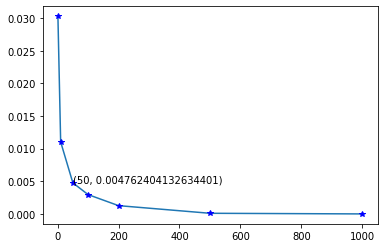

In [ ]:
evr_k = []
for i in (k):
  evr_k.append(evr[i-1])
print(evr_k)
plt.plot(k, evr_k)
for i in range(len(k)):
  plt.plot(k[i], evr_k[i],'b*')
plt.text(k[2], evr_k[2], '({}, {})'.format(k[2], evr_k[2]))
plt.show()

In [ ]:
lsi = TruncatedSVD(n_components=50, n_iter=20, random_state=42)
lsi_train = lsi.fit_transform(X_train)
lsi_test = lsi.transform(X_test)

In [ ]:
def linear_svm(train_set, test_set, train_label, test_label, gamma='auto', C=1.0):
    plt.gcf().clear()
    svc = svm.SVC(C = C, probability=False, kernel='linear')
    svc.fit(train_set, train_label)
    svc_predicted = svc.predict(test_set)

    print('gamma: '+ str(C))
    print('Accuracy: ' + str(metrics.accuracy_score(test_label.ravel(), svc_predicted)))
    print('Precision: ' + str(metrics.precision_score(test_label.ravel(), svc_predicted, average="macro")))
    print('Recall: ' + str(metrics.recall_score(test_label.ravel(), svc_predicted, average="macro")))
    print('F-1 Score: ' + str(metrics.f1_score(test_label.ravel(), svc_predicted, average="macro")))
    print('-' * 50)
    print("ROC Curve")
    roc_curve = RocCurveDisplay.from_estimator(
                                                  svc, test_set, test_label
                                              )
    plt.show()
    
    fpr, tpr, thresholds = metrics.roc_curve(test_label, svc.decision_function(test_set),pos_label=1)
    return fpr, tpr

In [ ]:
print(train_labels)

[4. 4. 3. ... 1. 4. 1.]


In [ ]:
fpr,tpr = linear_svm(lsi_train, lsi_test, train_labels, test_labels, C=1000)